# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

# Part 1: Get the data

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

Using TensorFlow backend.


IndexError: list index out of range

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on.

Question 1: What graphics card is available in the cloud machine? Run 'nvidia-smi' in the terminal. 

Question 2: Google the name of the graphics card, how many CUDA cores does it have?

Question 3: How much memory does the graphics card have?

Question 4: What is stored in the GPU memory while training a DNN ?

Question 5: What CPU is available in the cloud machine? How many cores does it have? Run 'lscpu' in the terminal.

Question 6: How much CPU memory (RAM) is available in the cloud machine? Run 'free -g' in the terminal.

###  Answers Q1-Q6
Q1: Tesla K80

Q2: 4992 NVIDIA CUDA cores

Q3: 24 GB of GDDR5 (graphics double data rate type five synchronous DRAM) memory

Q4: The network parameters and gradients 

Q5: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz. Each CPU has 6 cores. There are 6 CPUs in the cloud machine. 

Q6: 55 GB

# Part 4: Load the data

Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. 

We will use the function `genfromtxt` to load the data.

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.




In [2]:
from numpy import genfromtxt
import numpy as np

# Load data from file
#X = np.genfromtxt('Mirai_dataset.csv', delimiter=',')
#Y = np.genfromtxt('Mirai_labels.csv', delimiter=',')

# Save data as numpy arrays, for faster loading in future calls to this cell
#np.save('Mirai_data.npy', X)
#np.save('Mirai_labels.npy', Y)

# Load data from numpy arrays, for faster loading
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')

# Remove the first 24 covariates
X = X[:, 24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
print('Class 0 (=Benign) has {} examples.'.format(np.count_nonzero(Y==0)))
print('Class 1 (=Malicious) has {} examples.'.format(np.count_nonzero(Y==1)))

The covariates have size (764137, 68).
The labels have size (764137,).
Class 0 (=Benign) has 121621 examples.
Class 1 (=Malicious) has 642516 examples.


# Part 5: How good is a naive classifier?

Question 7: Given the distribution of examples, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by random chance.

In [3]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()

# Print the number of NaNs (not a number) in the labels
print('The number of NaNs (not a number) in the labels : {}'.format(sum(np.isnan(Y))))

# Print the number of NaNs in the covariates
print('The number of NaNs in the covariates : {}'.format(np.sum(np.isnan(X))))

The number of NaNs (not a number) in the labels : 0
The number of NaNs in the covariates : 0


### Answer Q7 

Q7: We can see from the code below that the naive classifier 1 that simply classifies all network packets as Malicious attacks has a high classification accuracy just by chance. While the other naive classifier 0 has quite a low accuracy.

In [4]:
total_examples = len(Y)

# If the naive classifier assumes all examples belong to the Malicious class 
correctly_classified1 = np.count_nonzero(Y==1)
classifier_accuracy1  = correctly_classified1 / total_examples

# If the naive classifier assumes all examples belong to the Benign class 
correctly_classified0 = np.count_nonzero(Y==0)
classifier_accuracy0  = correctly_classified0 / total_examples

print('Performance of the naive classifier 1 : {}'.format(classifier_accuracy1))
print('Performance of the naive classifier 0 : {}'.format(classifier_accuracy0))

Performance of the naive classifier 1 : 0.8408387501194158
Performance of the naive classifier 0 : 0.15916124988058425


# Part 6: Preprocessing

Lets do some simple preprocessing

In [5]:
# Convert covariates to floats
X.astype(float)

# Convert labels to ints
Y.astype(int)

# Remove mean of each covariate (column)
X = X - np.mean(X, axis=0)

# Divide each covariate (column) by its standard deviation
X = X / np.std(X, axis=0)

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print('Mean of covariates {}'.format(np.round(np.mean(X, axis=0))))
print('SD of covariates {}'.format(np.std(X, axis=0))) 

Mean of covariates [-0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0.
 -0. -0. -0. -0. -0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0.  0.  0. -0.  0.  0. -0. -0. -0.  0.  0.  0.
  0. -0. -0. -0.  0. -0. -0.  0. -0. -0.  0.  0.  0. -0.]
SD of covariates [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)


In [6]:
# Split the data into training (70%), validation and test (30%)
n      = len(Y)
split  = round(0.7*n)

Xtrain = X[0:split, ]
Ytrain = Y[0:split]

Xtemp  = X[split:, ]
Ytemp  = Y[split:]

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
print('\nNumber of class 0 examples in:' + 
      '\n\ttraining data : {}'.format(np.count_nonzero(Ytrain==0)) +
      '\n\tremaining 30% : {}'.format(np.count_nonzero(Ytemp==0)))

print('\nNumber of class 1 examples in:' + 
      '\n\ttraining data : {}'.format(np.count_nonzero(Ytrain==1)) +
      '\n\tremaining 30% : {}'.format(np.count_nonzero(Ytemp==1)))

Xtrain has size (534896, 68).
Ytrain has size (534896,).
Xtemp has size (229241, 68).
Ytemp has size (229241,).

Number of class 0 examples in:
	training data : 121621
	remaining 30% : 0

Number of class 1 examples in:
	training data : 413275
	remaining 30% : 229241


# Part 8: Number of examples per class

Question 8: Can we use the dataset as it is? Why not?

Lets randomly shuffle the data, to get some examples of each class in training data and in the remaining 30%. Use the function `shuffle` in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html

### Answer Q8

Q8: We cannot use the datasets as it is because the classes are not uniformly distributed between the training and test datasets. There are no instances of class 0 in the test dataset. 

In [7]:
from sklearn.utils import shuffle

# Randomly shuffle data, to get both classes in training and testing
X, Y   = shuffle(X, Y)

# Divide the data into training and validation/test again
Xtrain = X[0:split, ]
Ytrain = Y[0:split]

Xtemp  = X[split:, ]
Ytemp  = Y[split:]

# Print the number of examples of each class, for the training data and the remaining 30%
print('\nNumber of class 0 examples in:' + 
      '\n\ttraining data : {}'.format(np.count_nonzero(Ytrain==0)) +
      '\n\tremaining 30% : {}'.format(np.count_nonzero(Ytemp==0)))

print('\nNumber of class 1 examples in:' + 
      '\n\ttraining data : {}'.format(np.count_nonzero(Ytrain==1)) +
      '\n\tremaining 30% : {}'.format(np.count_nonzero(Ytemp==1)))


Number of class 0 examples in:
	training data : 85204
	remaining 30% : 36417

Number of class 1 examples in:
	training data : 449692
	remaining 30% : 192824


#  Part 9: Split non-training data data into validation and test
Split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [8]:
from sklearn.model_selection import train_test_split

Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5)
print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114620, 68), (114621, 68), (114620,) and (114621,)


# Part 10: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [9]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy as BC
from keras.layers import BatchNormalization, Dropout

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='SGD', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    optim = eval(optimizer)(lr=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    
    # Add batch normalization after the first layer
    if use_bn==True:
        model.add(BatchNormalization())
    
    # Add dropout after the first layer
    if use_dropout==True:
        if use_custom_dropout==True:
            model.add(myDropout(rate=0.5))            
        model.add(Dropout(rate=0.5))
            
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        
        # Add batch normalization after each dense layer
        if use_bn==True:
            model.add(BatchNormalization())
        
        # Add dropout after each dense layer
        if use_dropout==True:
            if use_custom_dropout==True:
                model.add(myDropout(rate=0.5))               
            model.add(Dropout(0.5))
            
    # Final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss=BC, optimizer=optim, metrics=['accuracy'])
    
    return model

In [10]:
# Lets define a help function for plotting the training results

# IMPORTANT NOTE
# The history unfortunately behaves a bit randomly for every user
# If the plots for accuracy and loss look mixed, change the order of
# val_loss, val_acc, loss, acc
# until the plots look as they "should"

import matplotlib.pyplot as plt
def plot_results(history):
    val_loss, val_acc, loss, acc = history.history.values()

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 11: Train the DNN

Time to train the DNN, we start simple with 2 layers with 2 nodes each, learning rate 0.1.

### 2 layers, 20 nodes

In [1]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build the model
model1 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval))

NameError: name 'Xtrain' is not defined

In [12]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.1864
Test accuracy: 0.8980


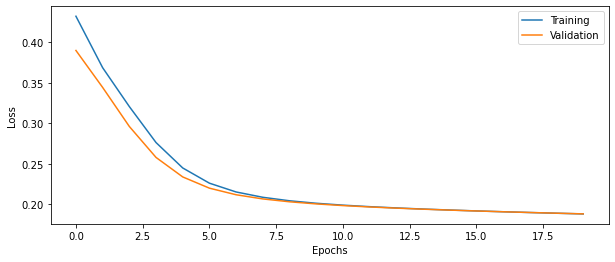

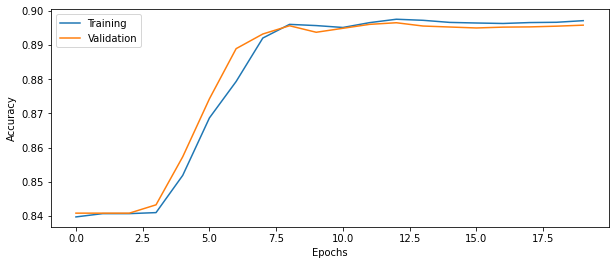

In [13]:
# Plot the history from the training run
plot_results(history1)

# Part 12: More questions

Question 9: What happens if you add several Dense layers without specifying the activation function?

Question 10: How are the weights in each dense layer initialized as default? How are the bias weights initialized?


### Answers Q9-Q10

Q9: Adding a dense layer without specifying the activation function is the same as using a linear (identity) activation function because that is the default activation in keras. The test loss has reduced to 0.17 and the accuracy has increased to 0.91 when compared to sigmoid activation in the dense layers.

Q10: We can see that the weights and biases are initialized to values less close to zero and less than 1. In keras, the the default kernel initializer for weights is glorot_uniform (also known as xavier's initialization) and the bias initializer is zeroes. Hence, the initial weights are random samples drawn from a normal distribution with mean=0 and stddev=sqrt(2/n) where n is the number of units in the layer and the biases are initialized to zeros.


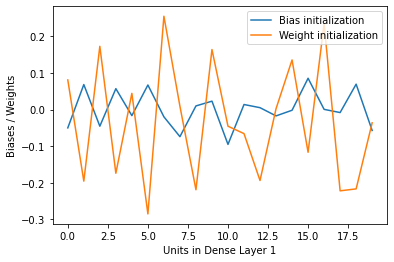

In [14]:
import matplotlib.pyplot as plt
biases  = model1.get_weights()[1:6:2]
weights = model1.get_weights()[0:5:2]

plt.plot(biases[0], label=f"Bias initialization")
plt.plot(weights[0][0], label=f"Weight initialization")
plt.xlabel(f"Units in Dense Layer 1")
plt.ylabel(f"Biases / Weights")
plt.legend()

# Part 13: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [15]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Ytrain), y=Ytrain)

# Print the class weights
print('The class weights for classes 0 and 1 are respectively {}'.format(class_weights))

The class weights for classes 0 and 1 are respectively [3.13891367 0.59473595]


### 2 layers, 20 nodes, class weights

In [16]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train model
model2 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.4078 - accuracy: 0.8407 - val_loss: 0.3893 - val_accuracy: 0.8408
Epoch 2/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.3700 - accuracy: 0.8407 - val_loss: 0.3480 - val_accuracy: 0.8408
Epoch 3/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.3257 - accuracy: 0.8407 - val_loss: 0.3022 - val_accuracy: 0.8408
Epoch 4/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.2818 - accuracy: 0.8407 - val_loss: 0.2627 - val_accuracy: 0.8411
Epoch 5/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.2484 - accuracy: 0.8511 - val_loss: 0.2364 - val_accuracy: 0.8633
Epoch 6/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.2277 - accuracy: 0.8719 - val_loss: 0.2211 - val_accuracy: 0.8752
Epoch 7/20
534896/534896 [==============================] - 

In [17]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])

print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.1841
Test accuracy: 0.9010


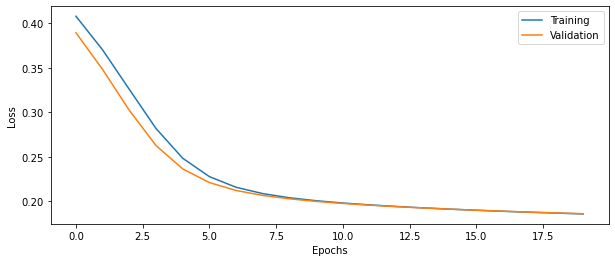

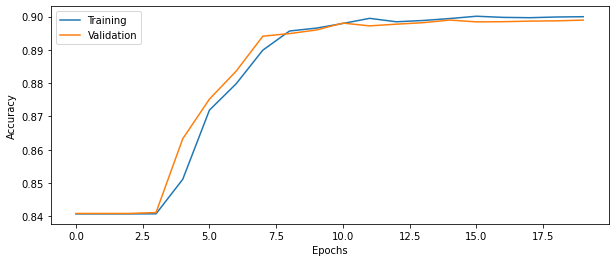

In [18]:
plot_results(history2)

# Part 14: More questions

Question 11: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the cloud computer a few times during training.

Question 13: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 14: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

Question 15: What limits how large the batch size can be?

Question 16: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

### Answers Q11-Q16

Q11: When the datasets are very large, we may not be able to fit the whole data in the machine memory. So we essentially process the data and train the network in batches. Large datasets may also consume a lot of resources. So we apply the calculations iteratively on a portion of the data to save time and computational resources. Very small batch sizes can exploit the parallel processing power of the GPU but the gradient descent will be more noisy because the gradent estimates based on small batches are less accurate. 

Q12: GPU is operating at a capacity of 31% of its full memory for batch size=100. 

Q13: 31% GPU memory and 12s per epoch for batch size=100, 33% GPU memory and 2s per epoch for batch size=1000, 21% GPU memory 1s per epoch for batch size=10000. We can see that as the batch size increases, the training time for one epoch decreases. As the batch size increases, the number of iterations in each epoch decreases and hence the training time decreases. 

Q14: When we specify a batch size the DNN will update the weights after passing the data samples in each batch. There are 534896 samples in the training dataset. For a batch size=100, weights will be updated 534896/100=5349 times in each epoch. Similarly, when batch size=1000 there will be 534896/1000=535 weight updates in each epoch. And when batch size=10000 weights will be updated 534896/10000=54 times in each epoch. As the batch size increases, the number of iterations in each epoch decreases and hence the training time decreases. 

Q15: The GPU memory and its computational capacity to perform parallel operations limit our choice of batch size. The larger the batch size, the more confident and sure we are of the loss gradient and less noise in the optimization path. If the batch size increases too much to contain the whole data, the loss gradient is calculated only after looking at all the samples in the dataset, which is computationally expensive. But we will get to the lowest gradient in the fewest number of steps. With a small batch size, the gradient descent will be more noisy, i.e. we will wander around a bit but the cost of computation of one gradient is trivial and will eventually reach the minimum. 

Q16: Larger batch size means that we have more data to compute the gradient and hence more confidence (accuracy) in the direction of the gradient descent. Hence we can get away with higher learning rates. When the batch size is decreased, the learning rate should also be decreased because the gradients are less accurate and the descent should be slow in order to not overshoot the optimum. 

**Notes:** If the batch size is too small, the training becomes slow because of significantly lower computational speed, because of not exploiting vectorization to the full extent. A larger batch size is more efficient computationally (up to a point) but while that might increase the number of samples processed, it can also mean that the number of SGD iterations taken decreases. With deep networks it's preferable to take many small steps than to take fewer larger ones (This design tradeoff requires experimentation to optimize for any given dataset/network)

# Part 15: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 17: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

### 4 layers, 20 nodes, class weights

In [19]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train model
model3 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=20, learning_rate=0.1)

history3 = model3.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 2s 4us/step - loss: 0.4445 - accuracy: 0.8409 - val_loss: 0.4415 - val_accuracy: 0.8390
Epoch 2/20
534896/534896 [==============================] - 2s 4us/step - loss: 0.4382 - accuracy: 0.8409 - val_loss: 0.4414 - val_accuracy: 0.8390
Epoch 3/20
534896/534896 [==============================] - 2s 4us/step - loss: 0.4381 - accuracy: 0.8409 - val_loss: 0.4412 - val_accuracy: 0.8390
Epoch 4/20
534896/534896 [==============================] - 2s 5us/step - loss: 0.4380 - accuracy: 0.8409 - val_loss: 0.4411 - val_accuracy: 0.8390
Epoch 5/20
534896/534896 [==============================] - 2s 4us/step - loss: 0.4379 - accuracy: 0.8409 - val_loss: 0.4410 - val_accuracy: 0.8390
Epoch 6/20
534896/534896 [==============================] - 2s 4us/step - loss: 0.4377 - accuracy: 0.8409 - val_loss: 0.4409 - val_accuracy: 0.8390
Epoch 7/20
534896/534896 [==============================] - 

In [20]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 3us/step
Test loss: 0.4319
Test accuracy: 0.8424


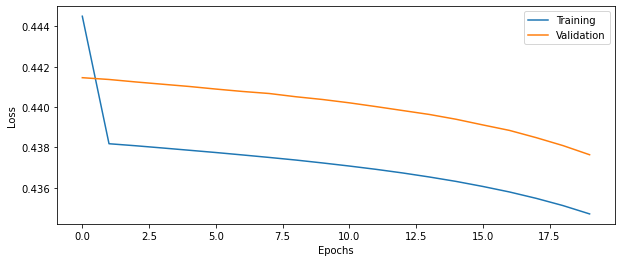

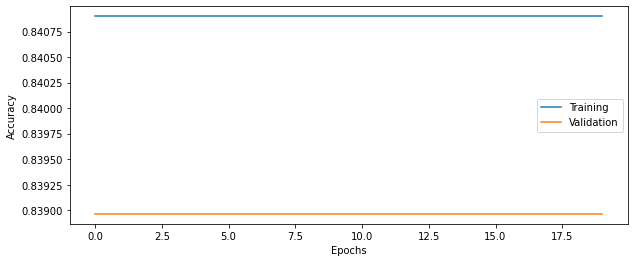

In [21]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [22]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train model
model4 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=50, learning_rate=0.1)

history4 = model4.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 3s 5us/step - loss: 0.4179 - accuracy: 0.8409 - val_loss: 0.3917 - val_accuracy: 0.8390
Epoch 2/20
534896/534896 [==============================] - 3s 5us/step - loss: 0.3625 - accuracy: 0.8409 - val_loss: 0.3342 - val_accuracy: 0.8390
Epoch 3/20
534896/534896 [==============================] - 2s 4us/step - loss: 0.3035 - accuracy: 0.8425 - val_loss: 0.2763 - val_accuracy: 0.8503
Epoch 4/20
534896/534896 [==============================] - 3s 5us/step - loss: 0.2554 - accuracy: 0.8552 - val_loss: 0.2391 - val_accuracy: 0.8583
Epoch 5/20
534896/534896 [==============================] - 2s 5us/step - loss: 0.2287 - accuracy: 0.8731 - val_loss: 0.2207 - val_accuracy: 0.8800
Epoch 6/20
534896/534896 [==============================] - 3s 5us/step - loss: 0.2156 - accuracy: 0.8812 - val_loss: 0.2114 - val_accuracy: 0.8834
Epoch 7/20
534896/534896 [==============================] - 

In [23]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 3us/step
Test loss: 0.1827
Test accuracy: 0.9052


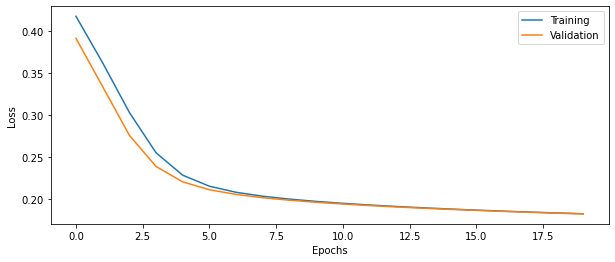

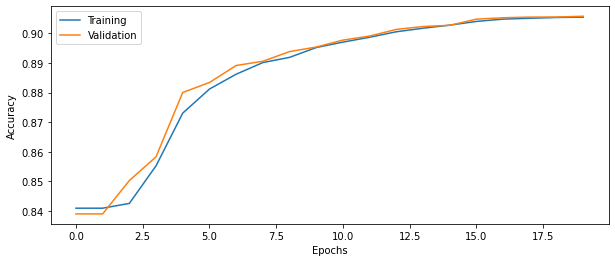

In [24]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [25]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train model
model5 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=50, learning_rate=0.1)

history5 = model5.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.4468 - accuracy: 0.8409 - val_loss: 0.4413 - val_accuracy: 0.8390
Epoch 2/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.4380 - accuracy: 0.8409 - val_loss: 0.4412 - val_accuracy: 0.8390
Epoch 3/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.4379 - accuracy: 0.8409 - val_loss: 0.4409 - val_accuracy: 0.8390
Epoch 4/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.4377 - accuracy: 0.8409 - val_loss: 0.4407 - val_accuracy: 0.8390
Epoch 5/20
534896/534896 [==============================] - 3s 5us/step - loss: 0.4375 - accuracy: 0.8409 - val_loss: 0.4406 - val_accuracy: 0.8390
Epoch 6/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.4372 - accuracy: 0.8409 - val_loss: 0.4403 - val_accuracy: 0.8390
Epoch 7/20
534896/534896 [==============================] - 

In [26]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 3us/step
Test loss: 0.4245
Test accuracy: 0.8424


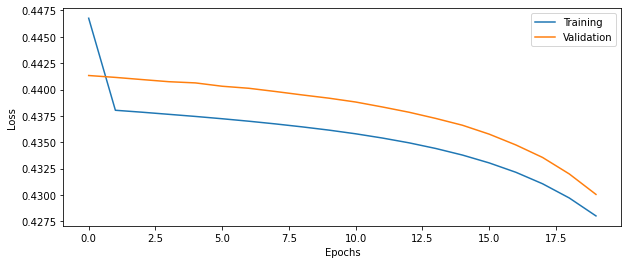

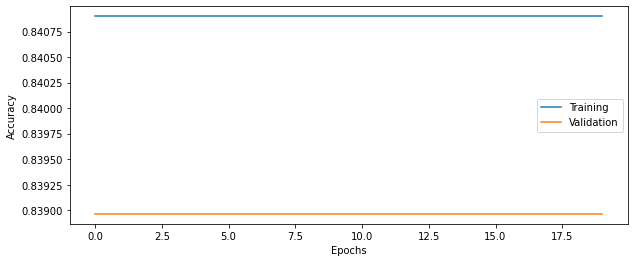

In [27]:
plot_results(history5)

In [28]:
model1.summary()
model5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                1380      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,821
Trainable params: 1,821
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 50)                3450      
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
______________________________

### Answer Q17

Q17: The network with 2 dense layers with 20 nodes each has a total of 1821 trainable parameters with 1360+400+20=1780 total weights and 20+20+1=41 total biases.  

1. The first deep layer has 68 inputs (from the input layer) to each of the 20 nodes. Hence it has 68 x 20=1360 weights and 20 biases.   
2. The second deep layer has 20 inputs (i.e. outputs from the nodes of previous layer) and 20 nodes. Hence it has 20 x 20=400 weights and 20 biases.  
3. The last node has 20 inputs and 1 node. So it has a 20 x 1=20 weights and 1 bias.  

$
\begin{align}
First  \ layer &= &1360 &\ weights + &20 &\ biases \\  
Second \ layer &= &400  &\ weights + &20 &\ biases \\  
Final  \ layer &= &20   &\ weights + &1  &\ bias   \\  
\end{align}
$  
  
  
The network with 4 dense layers with 50 nodes each has a total of 11,151 trainable parameters with 3400+2500+2500+2500+50=10950 total weights and 50+50+50+50+1=201 total biases.  

1. The first deep layer has 68 inputs (from the input layer) to each of the 50 nodes. Hence it has 68 x 50=3400 weights and 50 biases.   
2. The second, third and fourth deep layers each have 50 inputs (i.e. outputs from the nodes of previous layer) and 50 nodes. Hence each of them have 50 x 50=2500 weights and 50 biases.   
3. The last node has 50 inputs and 1 node. So it has a 50 x 1=50 weights and 1 bias.  

$
\begin{align}
First  \ layer &= &3400 &\ weights + &50 &\ biases \\
Second \ layer &= &2500 &\ weights + &50 &\ biases \\ 
Third  \ layer &= &2500 &\ weights + &50 &\ biases \\  
Fourth \ layer &= &2500 &\ weights + &50 &\ biases \\  
Final  \ layer &= &50   &\ weights + &1  &\ bias   \\
\end{align}
$


# Part 16: Batch normalization

Now add batch normalization after each dense layer. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 18: Why is batch normalization important when training deep networks?

### 2 layers, 20 nodes, class weights, batch normalization

In [29]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train model
model6 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, use_bn=True, learning_rate=0.1)

history6 = model6.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 4s 7us/step - loss: 0.3355 - accuracy: 0.8730 - val_loss: 0.4264 - val_accuracy: 0.8390
Epoch 2/20
534896/534896 [==============================] - 2s 5us/step - loss: 0.2074 - accuracy: 0.9009 - val_loss: 0.3964 - val_accuracy: 0.8390
Epoch 3/20
534896/534896 [==============================] - 2s 5us/step - loss: 0.1876 - accuracy: 0.9025 - val_loss: 0.3909 - val_accuracy: 0.8390
Epoch 4/20
534896/534896 [==============================] - 2s 4us/step - loss: 0.1798 - accuracy: 0.9048 - val_loss: 0.3715 - val_accuracy: 0.8390
Epoch 5/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.1752 - accuracy: 0.9067 - val_loss: 0.3332 - val_accuracy: 0.8390
Epoch 6/20
534896/534896 [==============================] - 2s 5us/step - loss: 0.1719 - accuracy: 0.9080 - val_loss: 0.2859 - val_accuracy: 0.8392
Epoch 7/20
534896/534896 [==============================] - 

In [30]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 2us/step
Test loss: 0.1562
Test accuracy: 0.9122


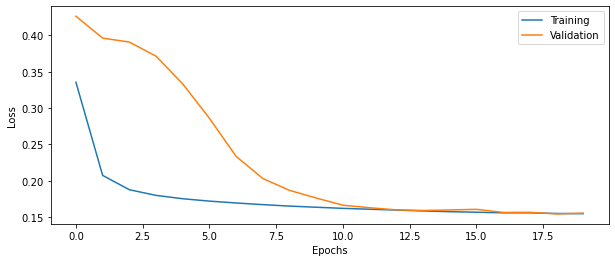

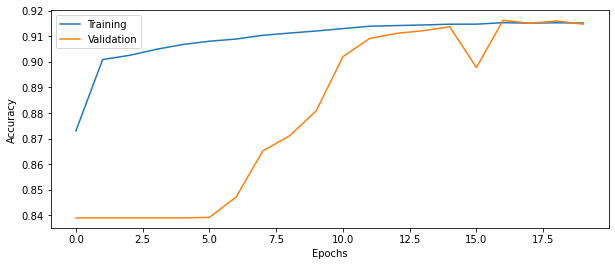

In [31]:
plot_results(history6)

### Answer Q18

Q18: Batch normalization normalizes the outputs from the activation function for each network layer to have zero mean and unit standard deviation. It helps model performance in the following ways:-
1. **Considerably increases the network training speed.**
When the covariates are on different scales, the gradient of the loss function along one axis may change slower compared to gradient along another axis. This means we need a smaller learning rate in order to not overshoot the optimum which makes the gradient based optimization slower. Batch normalization makes the loss optimization landscape smoother and hence speeds up training with higher learning rates. 

2. **Makes the network weights more stable/balanced and prevents exploding gradients, i.e. acts as a regularizer to control the influence of larger weights in the network.**
Imbalance in the non normalized data cause instabilility in the network and the relatively wide range of inputs can cause imbalanced gradients. With batch normalization, the relatively large inputs are scaled. The mean and variance of every activation is dependent on the batch of samples and hence this introduces some randomness/noise to the network which acts as a regularizer. 

3. **Makes the network weights in the deeper layers of the network more robust to changes to weights in the earlier layers of the network, i.e. allows each layer in the network learn a bit more independently.**  
This makes the network stable and less influenced by small changes in the input distribution. 

4. **Reduces the influence of the starting/initial weights on the network training time.**
When the initial weights are very far from the minimum of the loss function, with a small learning rate it will take more number of iterations to get to the minimum. With batch normalization, the loss function landscape is more smoother and irrespective of the starting weights, the minimum is reached in a similar number of iterations with faster learning rates. 

# Part 17: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [32]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train model
model7 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, act_fun='relu', learning_rate=0.1, use_bn=False)

history7 = model7.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 2s 4us/step - loss: 0.3077 - accuracy: 0.8791 - val_loss: 0.2055 - val_accuracy: 0.8895
Epoch 2/20
534896/534896 [==============================] - 2s 3us/step - loss: 0.1976 - accuracy: 0.8895 - val_loss: 0.1894 - val_accuracy: 0.8927
Epoch 3/20
534896/534896 [==============================] - 2s 3us/step - loss: 0.1865 - accuracy: 0.8939 - val_loss: 0.1819 - val_accuracy: 0.8987
Epoch 4/20
534896/534896 [==============================] - 2s 4us/step - loss: 0.1802 - accuracy: 0.9001 - val_loss: 0.1770 - val_accuracy: 0.9036
Epoch 5/20
534896/534896 [==============================] - 2s 3us/step - loss: 0.1759 - accuracy: 0.9056 - val_loss: 0.1736 - val_accuracy: 0.9085
Epoch 6/20
534896/534896 [==============================] - 2s 3us/step - loss: 0.1728 - accuracy: 0.9082 - val_loss: 0.1709 - val_accuracy: 0.9088
Epoch 7/20
534896/534896 [==============================] - 

In [33]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 2us/step
Test loss: 0.1602
Test accuracy: 0.9123


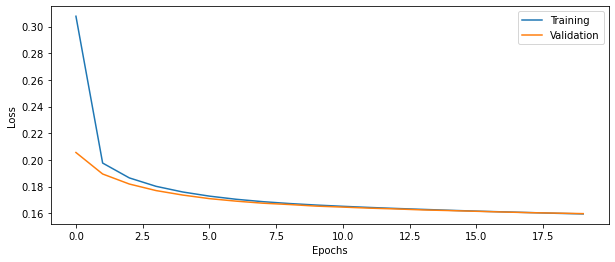

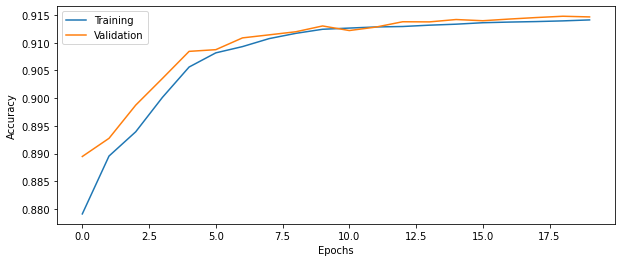

In [34]:
plot_results(history7)

# Part 18: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [35]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train model
model8 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='Adam', 
                   learning_rate=0.1, use_bn=False)

history8 = model8.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 2s 4us/step - loss: 0.2225 - accuracy: 0.8723 - val_loss: 0.1720 - val_accuracy: 0.9042
Epoch 2/20
534896/534896 [==============================] - 2s 3us/step - loss: 0.1676 - accuracy: 0.9071 - val_loss: 0.1634 - val_accuracy: 0.9134
Epoch 3/20
534896/534896 [==============================] - 2s 3us/step - loss: 0.1560 - accuracy: 0.9163 - val_loss: 0.1510 - val_accuracy: 0.9186
Epoch 4/20
534896/534896 [==============================] - 2s 3us/step - loss: 0.1479 - accuracy: 0.9188 - val_loss: 0.1474 - val_accuracy: 0.9178
Epoch 5/20
534896/534896 [==============================] - 2s 3us/step - loss: 0.1453 - accuracy: 0.9190 - val_loss: 0.1457 - val_accuracy: 0.9203
Epoch 6/20
534896/534896 [==============================] - 2s 3us/step - loss: 0.1436 - accuracy: 0.9197 - val_loss: 0.1434 - val_accuracy: 0.9204
Epoch 7/20
534896/534896 [==============================] - 

In [36]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 3us/step
Test loss: 0.1403
Test accuracy: 0.9180


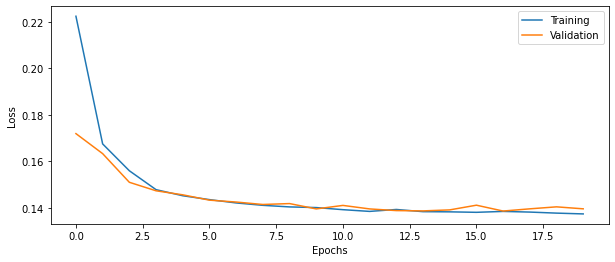

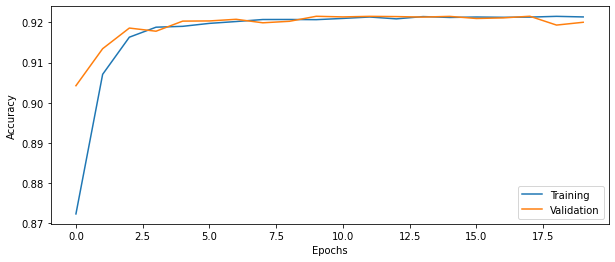

In [37]:
plot_results(history8)

# Part 19: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. 

Add a Dropout layer after each Dense layer (but not after the final dense layer), with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/layers/core/ for how the Dropout layer works.

---

Question 19: How does the validation accuracy change when adding dropout?

Question 20: How does the test accuracy change when adding dropout?

### Answers Q19-Q20

Q19: The validation accuracy has decreased from 0.92 to 0.89 when adding dropout

Q20: The test accuracy has also decreased from 0.92 to 0.89 when adding dropout

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [63]:
# Setup some training parameters
batch_size = 10
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train model
model9 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='SGD', 
                   learning_rate=0.1, use_bn=False, use_dropout=True)

history9 = model9.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Train on 687724 samples, validate on 114620 samples
Epoch 1/20
687724/687724 [==============================] - 286s 415us/step - loss: 0.1823 - accuracy: 0.8989 - val_loss: 0.1630 - val_accuracy: 0.9140
Epoch 2/20
687724/687724 [==============================] - 36762s 53ms/step - loss: 0.1674 - accuracy: 0.9096 - val_loss: 0.1596 - val_accuracy: 0.9159
Epoch 3/20
687724/687724 [==============================] - 102s 148us/step - loss: 0.1647 - accuracy: 0.9117 - val_loss: 0.1588 - val_accuracy: 0.9159
Epoch 4/20
687724/687724 [==============================] - 119s 173us/step - loss: 0.1636 - accuracy: 0.9125 - val_loss: 0.1578 - val_accuracy: 0.9171
Epoch 5/20
687724/687724 [==============================] - 106s 154us/step - loss: 0.1626 - accuracy: 0.9130 - val_loss: 0.1576 - val_accuracy: 0.9163
Epoch 6/20
687724/687724 [==============================] - 106s 155us/step - loss: 0.1618 - accuracy: 0.9134 - val_loss: 0.1558 - val_accuracy: 0.9179
Epoch 7/20
687724/687724 [=========

In [39]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 2us/step
Test loss: 0.2001
Test accuracy: 0.8930


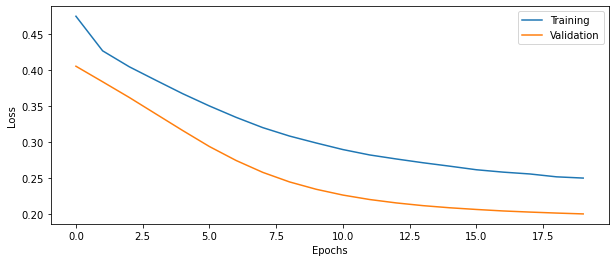

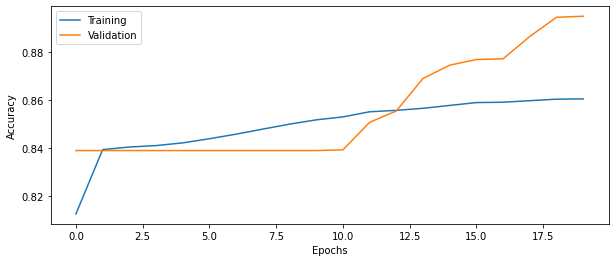

In [40]:
plot_results(history9)

# Part 20: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 21: How high classification accuracy can you achieve for the test data? What is your best configuration?

### Answer Q21

Q21: We are able to get a classification accuracy of upto 0.93 using the below hyperparameter settings:  
  
$
\begin{align}
batch size          &= &10000   \\
epochs              &= &20      \\ 
no of layers        &= &2       \\
no of nodes         &= &20      \\
activation          &= &sigmoid \\ 
optimizer           &= &Adam    \\ 
learning rate       &= &0.01    \\ 
batch normalization &= &True    \\ 
dropout             &= &False   \\  
\end{align}
$

A deeper network with 10 layers and 20 nodes took 2s more time to train per epoch when compared to a network with 2 layers and 20 ndes. 

In [23]:
# Find your best configuration for the DNN
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train DNN
model10 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='Adam', 
                    learning_rate=0.01, use_bn=True, use_dropout=False)

history10 = model10.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 2s 3us/step - loss: 0.2835 - accuracy: 0.8922 - val_loss: 0.6616 - val_accuracy: 0.8408
Epoch 2/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.1621 - accuracy: 0.9125 - val_loss: 0.6622 - val_accuracy: 0.8408
Epoch 3/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.1539 - accuracy: 0.9151 - val_loss: 0.5721 - val_accuracy: 0.8408
Epoch 4/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.1503 - accuracy: 0.9155 - val_loss: 0.4421 - val_accuracy: 0.8408
Epoch 5/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.1482 - accuracy: 0.9166 - val_loss: 0.3471 - val_accuracy: 0.8417
Epoch 6/20
534896/534896 [==============================] - 1s 2us/step - loss: 0.1456 - accuracy: 0.9181 - val_loss: 0.2391 - val_accuracy: 0.8582
Epoch 7/20
534896/534896 [==============================] - 

In [20]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.1390
Test accuracy: 0.9228


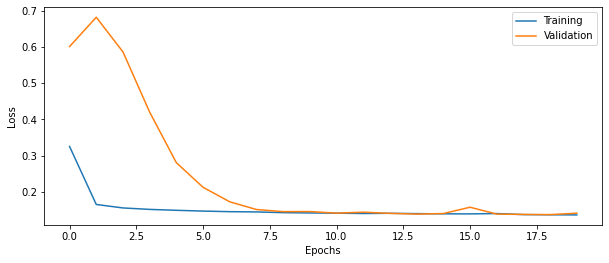

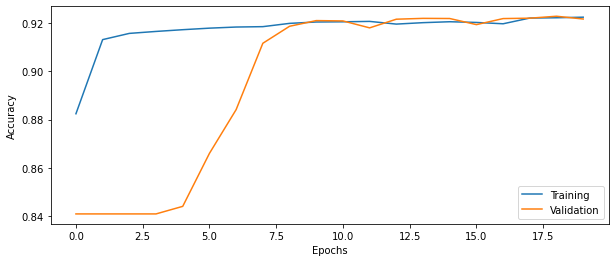

In [21]:
plot_results(history10)

# Part 21: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 22: What is the mean and the standard deviation of the test accuracy?

### Answer Q22

Q22: Using the best configuration of hyperparameters determined above and custom dropout, we got a mean of 0.913 and a standard deviation of 0.002 for the test accuracy

In [44]:
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [47]:
# Your best training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train model
model11 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='Adam', 
                    learning_rate=0.01, use_bn=True, use_dropout=True, use_custom_dropout=True)

history11 = model11.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

Train on 534896 samples, validate on 114620 samples
Epoch 1/20
534896/534896 [==============================] - 4s 8us/step - loss: 0.5045 - accuracy: 0.8221 - val_loss: 0.3592 - val_accuracy: 0.8390
Epoch 2/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.2443 - accuracy: 0.8812 - val_loss: 0.3623 - val_accuracy: 0.8390
Epoch 3/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.2021 - accuracy: 0.8908 - val_loss: 0.3047 - val_accuracy: 0.8390
Epoch 4/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.1899 - accuracy: 0.8949 - val_loss: 0.2392 - val_accuracy: 0.8390
Epoch 5/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.1849 - accuracy: 0.8974 - val_loss: 0.2009 - val_accuracy: 0.8391
Epoch 6/20
534896/534896 [==============================] - 3s 6us/step - loss: 0.1817 - accuracy: 0.8986 - val_loss: 0.1812 - val_accuracy: 0.8659
Epoch 7/20
534896/534896 [==============================] - 

In [50]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest, batch_size=batch_size)
                       
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 3us/step
Test accuracy: 0.9130


In [61]:
# Run the testing 100 times, and save the accuracies in an array
import numpy as np

accuracy = []
for i in range(100):
    score = model11.evaluate(Xtest, Ytest, batch_size=batch_size, verbose=2)
    accuracy.append(score[1])
    
# Calculate and print mean and std of accuracies
print('Mean Test accuracy: %.4f' % np.mean(accuracy))
print('SD of Test accuracy: %.4f' % np.std(accuracy))

Mean Test accuracy: 0.9146
SD of Test accuracy: 0.0001


# Part 22: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 23: What is the mean and the standard deviation of the test accuracy?

Question 24: What is the main advantage of dropout compared to CV for estimating test uncertainty?

### Answers Q23-Q24

Q23: We obtained a mean of 0.9232 and a standard deviation of 0.0018 for the test accuracy using 10 folds CV. 

Q24: The main disadvantage of CV for estimating the test uncertainty is the time taken for training the model. Using a 10 folds CV will take 10 times longer to train the model when compared to the dropout method. 

In [52]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define 10-fold cross validation
SKF = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

accuracy = list()
# Loop over cross validation folds
for train_idx, test_idx in SKF.split(X, Y):
    
    # Train/Test split for the current fold
    Xtrain, Xtest = X[train_idx, ], X[test_idx, ]
    Ytrain, Ytest = Y[train_idx], Y[test_idx]
    
    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Ytrain), y=Ytrain)

    # Best training hyper parameters
    batch_size = 10000
    epochs = 20
    input_shape = (Xtrain.shape[1], )

    # Rebuild the DNN model, to not continue training on the previously trained model
    model = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, act_fun='sigmoid', optimizer='Adam', 
                      learning_rate=0.01, use_bn=True, use_dropout=False)
    
    # Fit the model with training set and class weights for this fold
    model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)
    
    # Evaluate the model using the test set for this fold
    score = model.evaluate(Xtest, Ytest, batch_size=batch_size)
        
    # Save the test accuracy in an array
    accuracy.append(score[1])

Train on 687723 samples, validate on 114620 samples
Epoch 1/20
687723/687723 [==============================] - 4s 5us/step - loss: 0.2542 - accuracy: 0.9011 - val_loss: 0.5860 - val_accuracy: 0.8390
Epoch 2/20
687723/687723 [==============================] - 3s 4us/step - loss: 0.1548 - accuracy: 0.9151 - val_loss: 0.5325 - val_accuracy: 0.8390
Epoch 3/20
687723/687723 [==============================] - 3s 4us/step - loss: 0.1498 - accuracy: 0.9158 - val_loss: 0.3547 - val_accuracy: 0.8390
Epoch 4/20
687723/687723 [==============================] - 3s 4us/step - loss: 0.1467 - accuracy: 0.9177 - val_loss: 0.2372 - val_accuracy: 0.8442
Epoch 5/20
687723/687723 [==============================] - 3s 4us/step - loss: 0.1452 - accuracy: 0.9184 - val_loss: 0.1766 - val_accuracy: 0.8801
Epoch 6/20
687723/687723 [==============================] - 3s 4us/step - loss: 0.1433 - accuracy: 0.9193 - val_loss: 0.1458 - val_accuracy: 0.9183
Epoch 7/20
687723/687723 [==============================] - 

In [53]:
# Calculate and print mean and std of accuracies
print('Mean Test accuracy: %.4f' % np.mean(accuracy))
print('SD of Test accuracy: %.4f' % np.std(accuracy))

Mean Test accuracy: 0.9226
SD of Test accuracy: 0.0032


# Part 23: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 25: How would you change the DNN in order to use it for regression instead?

### Answer Q25

Q25: By replacing the loss function to Minimum Squared Error, the DNN can be used for regression instead of binary classification

In [54]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adam
from keras.losses import mean_squared_error as MSE
from keras.layers import BatchNormalization, Dropout

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN2(input_shape, n_layers, n_nodes, act_fun='relu', optimizer='Adam', learning_rate=0.01, 
               use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    optim = eval(optimizer)(lr=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    
    # Add batch normalization after the first layer
    if use_bn==True:
        model.add(BatchNormalization())
    
    # Add dropout after the first layer
    if use_dropout==True:
        if use_custom_dropout==True:
            model.add(myDropout(rate=0.5))            
        model.add(Dropout(rate=0.5))
            
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        
        # Add batch normalization after each dense layer
        if use_bn==True:
            model.add(BatchNormalization())
        
        # Add dropout after each dense layer
        if use_dropout==True:
            if use_custom_dropout==True:
                model.add(myDropout(rate=0.5))               
            model.add(Dropout(0.5))
            
    # Final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss=MSE, optimizer=optim, metrics=['mae'])
    
    return model

In [55]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1], )

# Build and train model
RegModel = build_DNN2(input_shape, n_layers=2, n_nodes=20, act_fun='relu', optimizer='Adam', learning_rate=0.01, 
                      use_bn=False, use_dropout=False, use_custom_dropout=False)

RegModel.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, validation_data=(Xval, Yval), class_weight=class_weights)

# Evaluate DNN on test data
score = RegModel.evaluate(Xtest, Ytest, batch_size=batch_size)
print('MSE score: %.4f' % score[0])

Train on 687724 samples, validate on 114620 samples
Epoch 1/20
687724/687724 [==============================] - 3s 4us/step - loss: 0.0663 - mae: 0.1405 - val_loss: 0.0542 - val_mae: 0.1116
Epoch 2/20
687724/687724 [==============================] - 3s 4us/step - loss: 0.0527 - mae: 0.1072 - val_loss: 0.0525 - val_mae: 0.1057
Epoch 3/20
687724/687724 [==============================] - 3s 4us/step - loss: 0.0510 - mae: 0.1037 - val_loss: 0.0507 - val_mae: 0.1021
Epoch 4/20
687724/687724 [==============================] - 2s 3us/step - loss: 0.0503 - mae: 0.1018 - val_loss: 0.0499 - val_mae: 0.1021
Epoch 5/20
687724/687724 [==============================] - 3s 4us/step - loss: 0.0499 - mae: 0.1005 - val_loss: 0.0499 - val_mae: 0.1012
Epoch 6/20
687724/687724 [==============================] - 3s 5us/step - loss: 0.0497 - mae: 0.1000 - val_loss: 0.0493 - val_mae: 0.0997
Epoch 7/20
687724/687724 [==============================] - 3s 4us/step - loss: 0.0491 - mae: 0.0991 - val_loss: 0.0488 

## Report

Send in this jupyter notebook, with answers to all questions.